# MDLE - Exercise 1.1
### Collaborative Filtering
##### Authors: Pedro Duarte 97673, Pedro Monteiro 97484

Import necessary modules

In [1]:
import math

import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import pairwise_distances

from matplotlib import pyplot as plt

from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession

from operator import add

Declare constants

In [2]:
# Spark Constants
APP_NAME = 'assignment1'
MASTER = 'local[*]'

# Input Constants
INPUT_METADATA_FILE = 'tracks.csv'
INPUT_FEATURES_FILE = 'features.csv'

# Data Columns
COLUMN_TRACK_ID = 'track_id'
COLUMN_SUBSET = 'set_subset'

# Application Constants
SUBSET_SMALL_VALUE = 'small'

Read CSV files and store the data in Pandas dataframes
- tracks: dataset consists of 106,574 music tracks
- features: 518 features, corresponding to 7 statistics (mean, standard deviation, skew, kurtosis, median, minimum, maximum) calculated from 74 time-based acoustic characteristics

In [3]:
tracks = pd.read_csv(INPUT_METADATA_FILE, index_col=0, header=[0, 1]) # has 2 header rows
features = pd.read_csv(INPUT_FEATURES_FILE, index_col=0, header=[0, 1, 2]) # has 3 header rows

Filter the `tracks` dataframe:
- condition checks if the value in the subset column of the set multi-level column index is equal to the string `small`. <br>

After that is expected to have only 8000 rows.

In [4]:
small = tracks[tracks['set', 'subset'] == 'small']
small.shape # get shape of dataframe => 8000 rows

(8000, 52)

Create a python set `ids` which contains the elements of the index of the `small`Pandas DataFrame

In [5]:
ids = set(small.index.to_list())

Select the rows from `features` dataframe that have an index in `ids`

In [6]:
features_sm = features.loc[ids]
features_sm.shape # get shape of dataframe => (8000, 518)
                  # should be 8000 tracks and 518 features

/tmp/ipykernel_27339/89041036.py:1: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  features_sm = features.loc[ids]


(8000, 518)

Using the `StandardScaler`, from scikit-learn, to standardize the values of features_sm dataframe

In [7]:
X = features_sm.values # extracts the values from the features dataframe 
X = StandardScaler().fit(X).transform(X) # X standardization

In [8]:
results = {}

for k in range(8, 17):
    clusters = AgglomerativeClustering(n_clusters=k).fit_predict(X)

    clusters_separated = [X[clusters == i] for i in range(k)]
    centroids = [cluster.mean(axis=0) for cluster in clusters_separated]

    radius = [max(np.linalg.norm(p - centroids[i]) for p in clusters_separated[i]) for i in range(k)]
    diameter = [np.max(pairwise_distances(cluster)) for cluster in clusters_separated]

    # !! division by 0 !!
    density_r = [len(clusters_separated[i]) / (radius[i]**2) if radius[i] != 0 else 0 for i in range(k)]
    density_d = [len(clusters_separated[i]) / (diameter[i]**2) if diameter[i] != 0 else 0 for i in range(k)]

    results[k] = {
        'radius': radius,
        'diameter': diameter,
        'density_r': density_r,
        'density_d': density_d,
    }

    print(f'For k = {k}:')
    print('Radius:', radius)
    print('Diameter:', diameter)
    print('Density (r2):', density_r)
    print('Density (d2):', density_d)
    print()

For k = 8:
Radius: [131.9635070863535, 85.61707555250149, 57.70367758776073, 108.58973665171192, 56.55991248912924, 0.0, 69.26651356236508, 0.0]
Diameter: [173.98817814544742, 104.32765325996061, 78.29800458030583, 138.6511252678381, 80.15796245946396, 0.0, 86.41438670574432, 0.0]
Density (r2): [0.12604534947908394, 0.19426260600852557, 0.9247039305792399, 0.005681947844095345, 0.3622980347779691, 0, 0.015423575461012385, 0]
Density (d2): [0.07250952221003852, 0.13083113598178184, 0.502236533071095, 0.003485202408848669, 0.1803807122132652, 0, 0.009909679658004903, 0]

For k = 9:
Radius: [57.70367758776073, 85.61707555250149, 131.53468744381067, 108.58973665171192, 56.55991248912924, 0.0, 69.26651356236508, 0.0, 73.19915536057896]
Diameter: [78.29800458030583, 104.32765325996061, 173.98817814544742, 138.6511252678381, 80.15796245946396, 0.0, 86.41438670574432, 0.0, 93.5137932752037]
Density (r2): [0.9247039305792399, 0.19426260600852557, 0.05670069902810301, 0.005681947844095345, 0.362

### 1.2

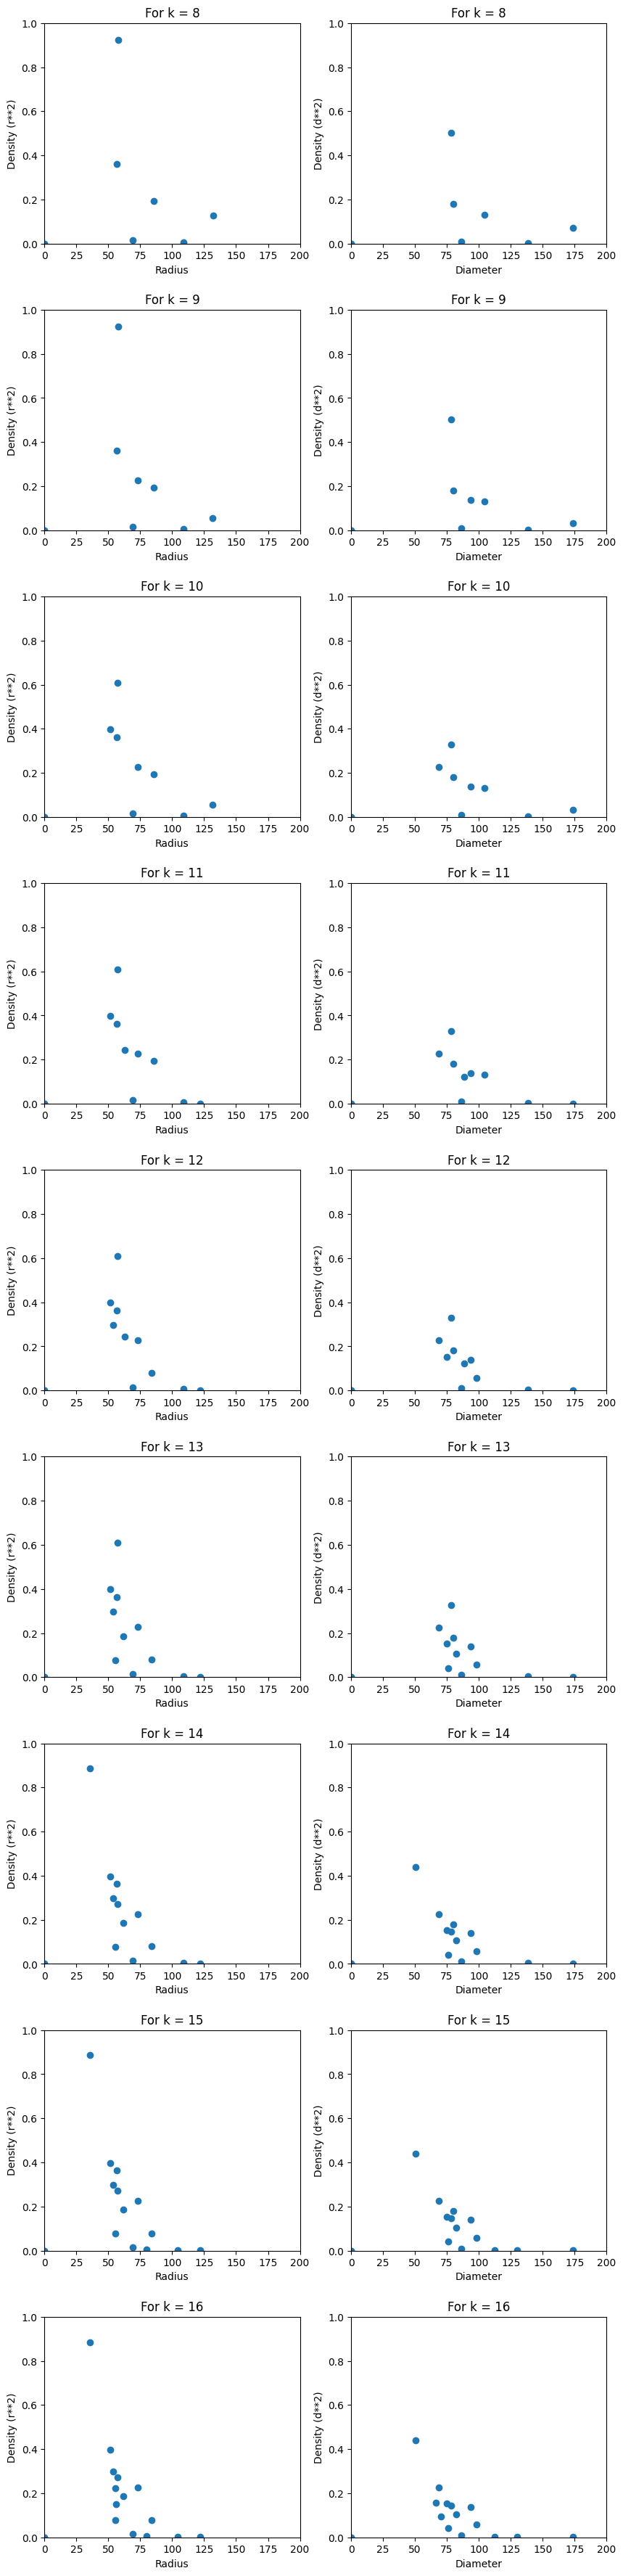

In [9]:
ks = list(results.keys())
fig = plt.figure()

fig.set_figwidth(10)
fig.set_figheight(45)
fig.set_animated(True)
fig.subplots_adjust(hspace=.3)

for i in range(len(ks)):
  k = ks[i]

  sub_r = fig.add_subplot(len(ks), 2, 2*i+1)
  sub_r.scatter(results[k]['radius'], results[ks[i]]['density_r'])
  sub_r.set_xlabel('Radius')
  sub_r.set_ylabel('Density (r**2)')
  sub_r.set_title(f'For k = {k}')
  sub_r.set_xlim([0, 200])
  sub_r.set_ylim([0, 1])

  sub_d = fig.add_subplot(len(ks), 2, 2*i+2)
  sub_d.scatter(results[k]['diameter'], results[ks[i]]['density_d'])
  sub_d.set_xlabel('Diameter')
  sub_d.set_ylabel('Density (d**2)')
  sub_d.set_title(f'For k = {k}')
  sub_d.set_xlim([0, 200])
  sub_d.set_ylim([0, 1])

plt.show()